### kernel для соревнования Rosbank ML Competition

ссылка на страницу соревнования https://boosters.pro/champ_15

Соревнование содержит в себе 2 задачи - нужно предсказать отток клиента и предсказать сумму его POS-транзакций за следующие 3 месяца.  

In [7]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import matplotlib.pyplot as plt
import re
import catboost
import lightgbm
import tsfresh
import pyprind
import warnings
import scipy
import lxml
import io
import requests
import os

In [101]:
pd.options.display.max_columns = 999
pd.options.display.max_info_rows = 300
pd.options.display.max_rows = 600
warnings.simplefilter('ignore')
PATH_TO_DATA = 'C:\\Users\\User\\ros_bank'

In [13]:
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from lxml import objectify
from tsfresh import extract_features
from scipy.stats import linregress

In [8]:
train_data = pd.read_csv(os.path.join(PATH_TO_DATA,'train.csv'),parse_dates=['PERIOD'],dayfirst=True)
test_data = pd.read_csv(os.path.join(PATH_TO_DATA,'test.csv'),parse_dates=['PERIOD'],dayfirst=True)

In [5]:
train_data.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,2017-10-01,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,2017-10-01,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,2017-12-01,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,2017-10-01,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,2017-10-01,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


Данные состоят из информации о транзакциях, каждая транзакция содержит в себе следующую информацию :
* PERIOD  месяц транзакции
* cl_id id клиента
* MCC код категории продавца
* channel_type eканал привлечения клиента
* currency валюта
* TRDATETIME дата/время транзакции
* amount сумма транзакции
* trx_category вид транзакции
    + POS – оплата через POS терминал 
    + C2C_OUT – перевод на карту (исходящий платёж) 
    + C2C_IN – перевод на карту (входящий платёж) 
    + DEPOSIT – пополнение карты в банкомате 
    + WD_ATM_PARTNER – снятие наличных в банкоматах партнерах
    + WD_ATM_ROS - снятие наличных в банкоматах росбанка
    + WD_ATM_OTHER - снятие наличных во всех других банкоматах
    + BACK_TRX - кэшбэк
    + CAT - внутренние банковские операции
* target_flag продолжит ли клиент пользоваться продуктом после льготного периода (1/0) (target)
* target_sum сумма транзакций вида POS за три будущих месяца (target)

для начала закодируем значения trc_category и channel_type

In [9]:
train_data.channel_type.fillna('type_nan',inplace=True)
test_data.channel_type.fillna('type_nan',inplace=True)

channel_coder =  LabelEncoder().fit(
    pd.concat((train_data.channel_type,test_data.channel_type),axis=0,ignore_index=True))
trx_coder = LabelEncoder().fit(
    pd.concat((train_data.trx_category,test_data.trx_category),axis=0,ignore_index=True) )

train_data.channel_type = channel_coder.transform(train_data.channel_type)
test_data.channel_type = channel_coder.transform(test_data.channel_type)
train_data.trx_category = trx_coder.transform(train_data.trx_category)
test_data.trx_category = trx_coder.transform(test_data.trx_category)

так же переведем даты в нормальный формат, развернем как dummy-переменную каждую trx_category для всех транзакций и сольем все данные в одну таблицу

In [10]:
month_dict = { 'JAN':1, 'FEB':2, 'MAR':3, 'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

#фуцкция переводит данные из транзакций к обычному DateTime
def parse_dates(row):
    x = row['TRDATETIME']
    y = row['PERIOD']
    day = x[:2]
    month = month_dict[x[2:5]]
    vals = x[6:].split(':')[:2]
    hour,minute = 0,0
    year = y.year
    return datetime.datetime(year,month,int(day))

#разворачивание dummy-переменных и слияние train и test таблиц в одну
dummy_name = ['trx_category']
test_data['target_flag'] = np.nan
test_data['target_sum'] = np.nan
all_data = pd.concat((train_data,test_data),axis=0,ignore_index=True) 
all_data = pd.get_dummies(all_data,columns=dummy_name)
all_data['norm_date'] = all_data[['PERIOD','TRDATETIME']].apply(parse_dates,axis=1)

#присвоим адекватные именна колонкам с dummy-переменными trx_type
trx_category_fea_name = [ fea for fea in all_data if re.match('trx_category',fea) ]
trx_name_dict = {  old:'trx_'+new for old,new in zip(trx_category_fea_name,trx_coder.classes_  ) }
all_data.rename(trx_name_dict,inplace=True,axis=1)
trx_category_fea_name = list(trx_name_dict.values())

взглянем на то какие валюты есть и как часто использовались 

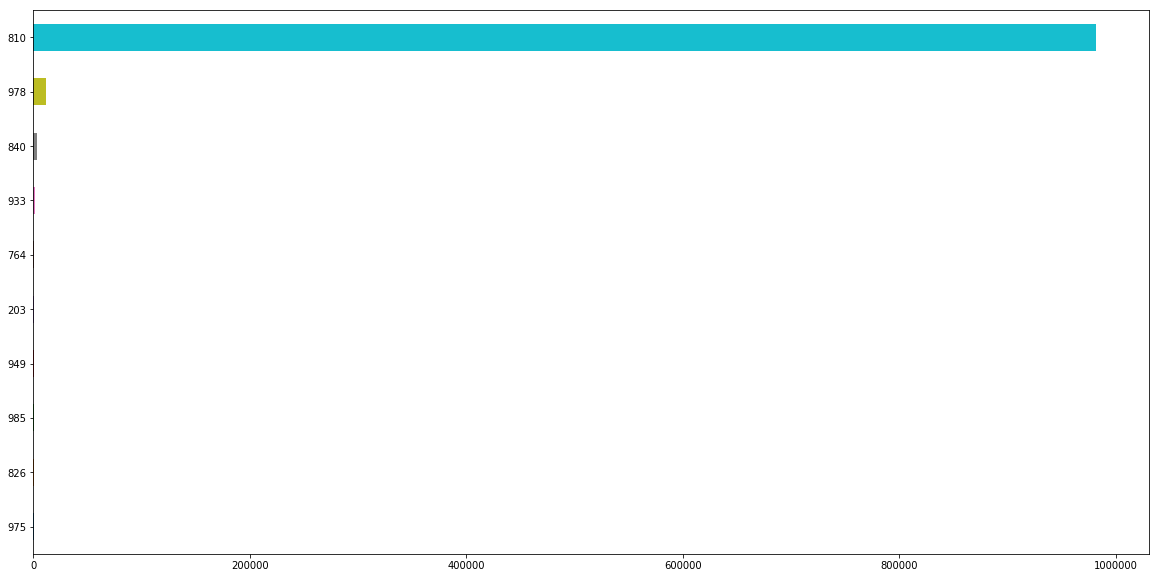

In [21]:
all_data.currency.value_counts().sort_values(ascending=True)[-10:].plot(kind = 'barh',figsize=(20,10))

хоть подавляющее количество операций и совершается в рублях, будет не лишним привести оставшиеся транзацкции единой валюте(к рублю в данном случае). для этого воспользуемся API сбербанка

In [22]:
#получим набор уникальных значения дата - валюта
currency = all_data.query('currency!=810')[['currency','norm_date']].drop_duplicates().set_index('norm_date')
#и список уникальных валют
val_code_set = currency['currency'].unique()
#шаблон запроса к API, параметры - день,месяц,год
request_template = 'http://www.cbr.ru/scripts/XML_daily_eng.asp?date_req={}/{}/{}'

date_list = []
#будем получать полный список курсов валют на каждую интересующую дату
for date in currency.index.unique():
    ans = requests.get(request_template.format(date.day,date.month,date.year),
                       proxies=proxies
                      )
    #создание xml-дерева из запроса
    tree = objectify.parse(io.BytesIO(ans.content))
    root = tree.getroot()  
    #множество из интересующих курсов на эту дату
    val_code_set = set( currency.loc[date]['currency'].unique() if len(currency.loc[date])>1 else [ currency.loc[date]['currency'] ] )
    #проход по xml
    for valute in root.getchildren():
        children = valute.getchildren()
        # берем только интересующие нас валюты
        if children[0].pyval  not in val_code_set: continue
        date_list.append((date,children[0].pyval,children[4].pyval))

#преобрзуем список в фрейм с индексами в виде даты и типа валюты приводим курсы к нормальной форме(там разделитель косячный) ,
#мержим с нашими данными, и перемнодаем значения курса с суммой по транзакции
temp =  pd.DataFrame(date_list,columns=['norm_date','currency','vals']).set_index(['norm_date','currency'])
temp['vals'] = temp['vals'].map( lambda x : float(re.sub(',','.',x)) )
all_data = all_data.merge(left_on=['norm_date','currency'],right_index=True,right=temp,how='left')
all_data['vals'].fillna(1,inplace=True)
all_data['amount']*=all_data.vals   



Некоторые вспомогательные функции

In [71]:
#количество транзаций больше медианного значения
def extract_count_largets_transaction(amount,bar):
    median =  amount.median()
    mean =    amount.mean()
    res1=  (amount>median).sum()
    res2 = (amount>mean).sum()
    bar.update()
    return pd.Series( [res1.values[0],res2.values[0]],index=['mean_large_count','median_large_count'] )

#извлекает фичи основанные на временной динамике с соответсвующей функцией агрегации 
def calc_feature_base_on_date(group_object,columns_list,date_columns_name,extract_function,aggregate_method):
    bar = pyprind.ProgBar(iterations=len(columns_list))
    result_frame = group_object[[date_columns_name,columns_list[0]]].apply(extract_function,aggregate_method)
    bar.update()
    for fea in columns_list[1:]:
        res = group_object[[date_columns_name,fea]].apply(extract_function,aggregate_method)
        result_frame = pd.concat((result_frame,res),axis=1)
        bar.update()
    return result_frame

#отношения какого либо показателя за последние 3 месяца к общему суммарному значению за все время
def extract_partition_by_period_fea(df,aggregate_method):
    temp = df.set_index('norm_date').sort_index().resample('M').aggregate(
        aggregate_method).fillna(0).reset_index(drop=True)
    name = df.columns[1]
    total = temp.sum().loc[name]
    total = 1 if total < 1e-10 else total
    name_template = 'part_{}_{}'.format(aggregate_method,name)+'_{}'
    placeholder = pd.Series( np.zeros(3),name = 'partition_'+name,
                            index = [name_template.format(i+1) for i in range(3)] )
    
    len_temp = len(temp)
    len_temp = 3 if len_temp>=3 else len_temp 
    for i in range(len_temp):
        placeholder[name_template.format(i+1)] = temp.iloc[-i] / total
    #Tracer()()
    return placeholder


def calc_index_val(val1,val2):
    if np.all(val1 < 0+ 1e-10 ):
        return 0
    elif np.all(val2 < 0+1e-10):
        return 9999
    else :
        return val1 / val2
    
#'типа' эконометричесекие индексы отношение данны за последний месяц к 2 предыдущим 
def extract_index_fea(df,aggregate_method):
    res = np.zeros(2)
    temp = df.set_index('norm_date').sort_index().resample('M').aggregate(aggregate_method).fillna(0).reset_index(drop=True)
    if len(temp)==1:
        if temp.iloc[-1].values[0]>0:
            res[:] = 9999
    elif len(temp) == 2:
        res[1] = calc_index_val( temp.iloc[-1],temp.iloc[-2] )
        if temp.iloc[-1].values[0]>0:
            res[0] =9999
    elif len(temp)>=3:
        res[1] = calc_index_val(temp.iloc[-1],temp.iloc[-2])
        res[0] =  calc_index_val(temp.iloc[-1],temp.iloc[-3])
    name = df.columns[1]
    names = [ 'index_{}_{}_{}'.format(aggregate_method,name,order) for order in ['first','last']  ]
    return pd.Series(res,index = names)


corr_list = ['pearson', 'kendall', 'spearman']
corr_fea_name = ['corr_fea_pearson','corr_fea_kendall','corr_fea_spearman']
#корреляция между расходом и прихохом. по кросс-валидации зашли сразу все 3 вида, пусть все 3 и остануться
def extract_ts_correlation(df):
    df.set_index('norm_date',inplace=True)
    df.sort_index(inplace=True)
    df = df.resample('D').sum()[['amount_consuption','amount_coming']]
    res = np.zeros(3)
    for i,fea in enumerate(corr_list):
        res[i] = df.corr(fea).loc['amount_consuption','amount_coming']
    return pd.Series(res,index = corr_fea_name)


def extract_ts_diff(df,agg):
    res = np.zeros(2)
    temp = df.set_index('norm_date').sort_index().resample('M').sum().fillna(0).reset_index(drop=True)
    vals = temp.diff(1).values
    names = [ 'ts_diff_{}'.format(df.columns[1]) for i in range(2) ]
    if len(temp)>=3:
        res[1] = vals[-1]
        res[0] = vals[-2]
    elif len(temp==2):
        res[1] = vals[-1]
    return pd.Series(res,index = names )    

#линейная апроксмация расходов во времени
#возможно апроксимация построеннае по взвещенному скользящему среднему взошла бы лучше, но уже поздно проверять
def get_linear_trande(df,bar):
    df = df.set_index('norm_date').sort_index().resample('W').sum().fillna(0).reset_index(drop=True)
    name = df.columns[0]
    vals = StandardScaler().fit_transform(np.hstack((np.arange(len(df)).reshape(-1,1),df.values)))
    res = linregress(vals)
    bar.update()
    return pd.Series([res.slope,res.intercept], 
                     index = ['{}_slope'.format(name),'{}_intercept'.format(name)])

#считает переданные статистики на переданные стобцы. 
def calc_stat( groups, columns_lists,stats_list ):
    res = None
    for list_ in columns_lists:
        for stat in stats_list:
            names = name_generator( stat, list_ )
            result = groups[list_].aggregate(stat)
            result.columns = names
            if res is None:
                res = result
            else :
                res = pd.concat((res,result),axis=1)
    return res

name_generator =  lambda prefix,names: [ prefix+'_'+fea for fea in names ]

начнем с фичей, основанных на MCC  
прочитаем имена mcc кодов и посмотрим сколько приходиться на каждый MCC код

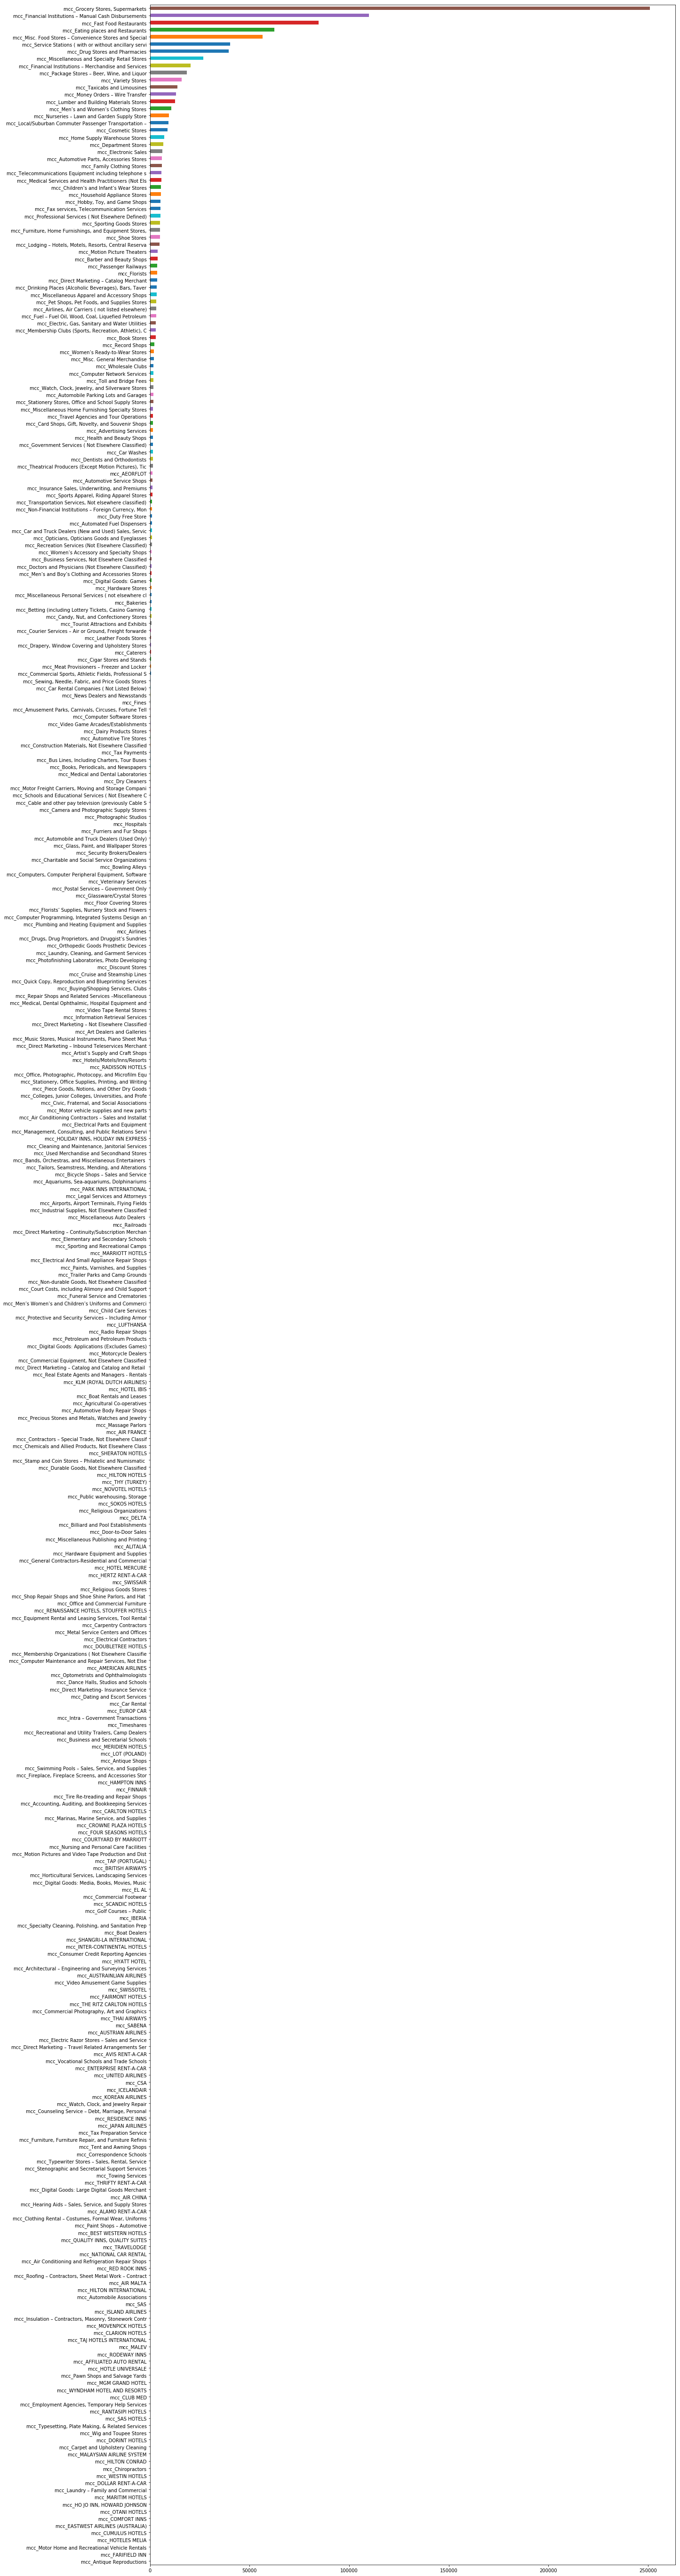

In [92]:
mcc_data = pd.read_csv(os.path.join(PATH_TO_DATA,'mcc_codes.csv'),
                       usecols=['mcc','edited_description'],index_col=0)['edited_description']
mcc_data.rename({'edited_description':'mcc_name'}) 
mcc_data = mcc_data.map( lambda x : 'mcc_'+x[:50] ) #обрежем имена
all_data.MCC.map(mcc_data).value_counts().sort_values().plot(kind = 'barh',figsize=(20,100))

подавляющее большинство транзакций приходиться только на несколько MCC кодов(что весьма очевидно, люди едят чаще, чем покупают машины)  
оставим 50 категорий с наибольшими значениями для анализа для анализа 

In [105]:
MCC_LIMIT = 50

mcc_dict = mcc_data.to_dict()
mcc_dict[-1] = 'mcc_other'
mcc_info = all_data[['MCC','amount','norm_date','cl_id']]

include_vals = set(mcc_info['MCC'].value_counts()[:MCC_LIMIT].index.tolist())

mcc_info.loc[:,'MCC'] = mcc_info.MCC.map( lambda x : -1 if x not in include_vals else x  ).map(mcc_dict)
#преобразуем MCC код в дамми переменные
mcc_info = pd.get_dummies(columns=['MCC'],data=mcc_info,)
mcc_name = [ fea for fea in mcc_info if re.match('MCC',fea) ]
mcc_amount = mcc_info.amount.values
#для каждой транзакции создадим таблицу данными о суммах по каждой MCC категории
mcc_amount_data = mcc_info[mcc_name].apply( lambda x : x * mcc_amount , axis=0 )
mcc_amount_data.loc[:,'cl_id'] = mcc_info.cl_id

In [107]:
#сгрупируем по идентификатору и насчитаем индекс за последние периоды
mcc_amount_group = mcc_amount_data.groupby(by='cl_id')
mcc_amount_data['norm_date'] = mcc_info['norm_date']
mcc_group_other = mcc_amount_data.groupby(by = 'cl_id')

mcc_partitional_data = calc_feature_base_on_date(mcc_group_other,
                                   columns_list=mcc_name,
                                   date_columns_name='norm_date',
                                   extract_function =extract_partition_by_period_fea,
                                   aggregate_method='sum' )
#и насчитаем описательные статистики тоже
mcc_fea = calc_stat( mcc_amount_group, [mcc_name], ['mean','sum','std','median','max','min']  )

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:33:03


In [45]:
#создадим таблицу которая содержит сумму транзакции на каждую из различных значений
amount_trx_category = name_generator('amount',trx_category_fea_name)
ammount_cols = all_data['amount'].values.reshape(-1,1)
trx_amount_data = pd.DataFrame(all_data[trx_category_fea_name].values*ammount_cols,
                               index=all_data.index,
                               columns=amount_trx_category)
data = pd.concat( (all_data,
                       trx_amount_data,
                      ),
                     axis=1 )

#каждая из trx категорий это либо приходит средств, либо их приход, объединим категории по этому признаку
consumption = [ 'trx_C2C_OUT', 'trx_CASH_ADV','trx_CAT','trx_POS','trx_WD_ATM_OTHER','trx_WD_ATM_PARTNER',
              'trx_WD_ATM_ROS'] 
coming = ['trx_BACK_TRX','trx_C2C_IN','trx_DEPOSIT']

amount_cosumption_name = name_generator('amount',consumption)
amount_coming_name = name_generator('amount',coming)

data['amount_consuption'] = np.sum(data[amount_cosumption_name],axis=1)
data['amount_coming'] = np.sum(data[amount_coming_name],axis=1)
data['consumption'] = np.any(data[consumption],axis=1).astype(np.int32)
data['coming'] =np.any(data[coming],axis=1).astype(np.int32)

#сгрупирруем данные по индексу и на каждый из столбцов насчитаем описательные статистики 
groups = data.groupby(by='cl_id')
amount_statistic_data = calc_stat( groups, [amount_trx_category],
                             stats_list=['sum','mean','median','std','min','max'] )
#посчитаем общее число транзакций для каждого клиента
counter_data = calc_stat(groups,[
                                 trx_category_fea_name,
                                ['consumption','coming']],
                         stats_list=['sum'])
#количество дней 
transaction_day_count = groups['norm_date'].nunique()
transaction_day_count.name = 'day_count'
#количество транзакций
transaction_count = groups['norm_date'].size()
transaction_count.name ='count'
#вся сумма переводов
amount_total = groups['amount'].sum()
amount_total.name = 'total_amount'
#разные отношение со всей суммой
amount_per_transaction = amount_total / transaction_count
amount_per_transaction.name = 'amount_per_transaction'
amount_per_day = amount_total / transaction_day_count
amount_per_day.name = 'amount_per_day'
transaction_per_day = transaction_count / transaction_day_count
transaction_per_day.name = 'transaction_per_day'
#канад привлечения, будет категориальной фичей
chanel_type = groups['channel_type'].last()
chanel_type.name = 'chanel_type'
#промежуток времени между певой и последней транзакцией
days = groups['norm_date'].aggregate(['max','min'])
days = (days['max'] - days['min']).map( lambda x : x.days )
days.name = 'time_period'
#отноешния количесва дней с транзакциями и количесва транзакций к числу дней
activity_relation_day = transaction_day_count / days
activity_relation_day.name = 'activity_relation_day'
activity_relation_transaction = transaction_count / days
activity_relation_transaction.name = 'activity_relation_transaction'
#отношения суммы по каждой из категорий к общей сумме транзакций
sum_name = ['sum_'+fea for fea in amount_trx_category]#+['sum_'+fea for fea in amount_mcc_name]
amount_proportion =amount_statistic_data[sum_name].apply(lambda x : x/amount_total )
amount_proportion.columns = [ re.sub('sum','proportion',fea) for fea in amount_proportion  ] 
#отношение всех дней к дням с транзакциями
intensity_fea = days / transaction_day_count
intensity_fea.name = 'instensity'
#и опять описательные статистики
amount_data = calc_stat(groups,[['amount_consuption','amount_coming']],
                        stats_list=['sum','mean','median','std','min','max'])
#и отношение разных сумму к разным счетчикам
amount_data['coming_per_days']  = amount_data['sum_amount_consuption'] / transaction_day_count
amount_data['consuption_per_days']  = amount_data['sum_amount_consuption'] / transaction_day_count
amount_data['coming_per_transaction'] = amount_data['sum_amount_consuption'] / transaction_count
amount_data['consuption_per_transaction'] = amount_data['sum_amount_coming'] / transaction_count

In [49]:
#отношение количества тразнакций с суммой выше медианной или выше средней к общечем числу транзакций
bar = pyprind.ProgBar(data.cl_id.nunique())
count_largest_trasnsactio = groups[['amount']].apply(extract_count_largets_transaction,bar)
count_largest_trasnsactio['rel_mean_largets'] = count_largest_trasnsactio.mean_large_count / transaction_count
count_largest_trasnsactio['rel_median_largest'] = count_largest_trasnsactio.median_large_count /  transaction_count

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10

Total time elapsed: 00:00:10


In [51]:
#разные кореляции между доходом и расходом
corr_ = groups.apply(extract_ts_correlation)  

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:3559: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


In [111]:
#индексы на разные переменные. считается д
amount_index_fea =  calc_feature_base_on_date(groups,
                                   columns_list=amount_trx_category+['amount_consuption','amount_coming'],
                                   date_columns_name='norm_date',
                                   extract_function =extract_index_fea,
                                   aggregate_method='sum' )
count_index_fea = calc_feature_base_on_date( groups,
                                            columns_list=trx_category_fea_name+['consumption','coming'],
                                           date_columns_name = 'norm_date',
                                           extract_function =extract_index_fea,
                                           aggregate_method='sum')
amount_partitional_data = calc_feature_base_on_date(groups,
                                   columns_list=amount_trx_category+['amount_consuption','amount_coming'],
                                   date_columns_name='norm_date',
                                   extract_function =extract_partition_by_period_fea,
                                   aggregate_method='sum' )
count_partitional_data = calc_feature_base_on_date(groups,
                                   columns_list=trx_category_fea_name+['consumption','coming'],
                                   date_columns_name='norm_date',
                                   extract_function =extract_partition_by_period_fea,
                                   aggregate_method='sum' )

0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:06:51
0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:07:19
0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:07:12
0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:08:02


In [113]:
#два последних значения производной временного ряда
ts_diffs_feature = calc_feature_base_on_date(groups,
                                   columns_list=amount_trx_category+['amount_consuption','amount_coming'],
                                   date_columns_name='norm_date',
                                   extract_function =extract_ts_diff,
                                   aggregate_method='sum' )

0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:06:00


In [114]:
#линейная апроксимация для временнынх рядов расходов и доходов, по неделям
bar = pyprind.ProgBar(len(groups))
trend_consumption = groups[['norm_date','amount_consuption']].apply(get_linear_trande,bar)
bar = pyprind.ProgBar(len(groups))
trend_coming = groups[['norm_date','amount_coming']].apply(get_linear_trande,bar)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30

Total time elapsed: 00:00:30
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29

Total time elapsed: 00:00:29


In [115]:
min_date = groups['norm_date'].apply(lambda x : x.min().toordinal())
min_date.name = 'min_day'
max_date = groups['norm_date'].apply(lambda x : x.max().toordinal())
max_date.name = 'max_day'
def extact_month_count(df):
    return df.map( lambda x : x.month ).nunique()
month_count = groups['norm_date'].apply(extact_month_count)
month_count.name = 'month_count'
#зачем это понадобилось я поясню ниже
decompose_fea = pd.DataFrame( PCA(n_components=2).fit_transform(pd.concat((max_date,min_date),axis=1).values),
                            index = min_date.index,
                            columns = ['decompose_PCA_1','decompose_PCA_2'])

In [142]:
df_features =  pd.concat( ( amount_statistic_data,
                           amount_proportion,
                           counter_data,
                           transaction_day_count,
                           transaction_count,
                           amount_total,
                           amount_per_transaction,
                           amount_per_day,
                           intensity_fea,
                           transaction_per_day,
                           amount_data,
                           corr_,
                           activity_relation_transaction,
                           activity_relation_day,
                           count_largest_trasnsactio,
                           chanel_type,
                           days,
                           count_partitional_data,
                           amount_partitional_data,
                           count_index_fea,
                           amount_index_fea,
                           amount_part_diffs,
                           mcc_fea,
                           mcc_partitional_data,
                           month_count,
                           min_date,
                           max_date,
                           trend_consumption,
                           trend_coming,
                           decompose_fea,
                         ),
                        axis=1,  )

df_features.loc[:,'chanel_type'] = pd.Categorical(df_features['chanel_type']) 
#cl_id является важнейшей переменной, как ни странно. скорей всего чем меньше айдишник, 
#тем дольше клиент пользуется уcлугами банка
df_features['magic'] =df_features.index

In [125]:
#простая модель для того чтобы взглянуть на feature importance

train_index,validate_index = train_test_split(train_data.cl_id.unique(),test_size=0.3,random_state=42)
target = train_data[['cl_id','target_flag']].drop_duplicates().set_index(['cl_id'])
train_set,train_target = df_features.loc[train_index], target.loc[train_index]
validate_set,validate_target = df_features.loc[validate_index], target.loc[validate_index]

model_lg = lightgbm.LGBMClassifier(learning_rate=0.04,num_leaves=26,
                                   n_estimators=110,subsample=0.7,colsample_bytree=0.6)
model_lg.fit(train_set,train_target,eval_set=[(validate_set,validate_target)],
          eval_metric='auc')

[1]	valid_0's auc: 0.843825
[2]	valid_0's auc: 0.843435
[3]	valid_0's auc: 0.853726
[4]	valid_0's auc: 0.855961
[5]	valid_0's auc: 0.857046
[6]	valid_0's auc: 0.859029
[7]	valid_0's auc: 0.859248
[8]	valid_0's auc: 0.859504
[9]	valid_0's auc: 0.858151
[10]	valid_0's auc: 0.858835
[11]	valid_0's auc: 0.859806
[12]	valid_0's auc: 0.859187
[13]	valid_0's auc: 0.859411
[14]	valid_0's auc: 0.860685
[15]	valid_0's auc: 0.860945
[16]	valid_0's auc: 0.863632
[17]	valid_0's auc: 0.86332
[18]	valid_0's auc: 0.864202
[19]	valid_0's auc: 0.864666
[20]	valid_0's auc: 0.865091
[21]	valid_0's auc: 0.865258
[22]	valid_0's auc: 0.866531
[23]	valid_0's auc: 0.866784
[24]	valid_0's auc: 0.86794
[25]	valid_0's auc: 0.868288
[26]	valid_0's auc: 0.868403
[27]	valid_0's auc: 0.868271
[28]	valid_0's auc: 0.869504
[29]	valid_0's auc: 0.869833
[30]	valid_0's auc: 0.869954
[31]	valid_0's auc: 0.869559
[32]	valid_0's auc: 0.869635
[33]	valid_0's auc: 0.869742
[34]	valid_0's auc: 0.869833
[35]	valid_0's auc: 0.870

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        learning_rate=0.04, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=110,
        n_jobs=-1, num_leaves=26, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

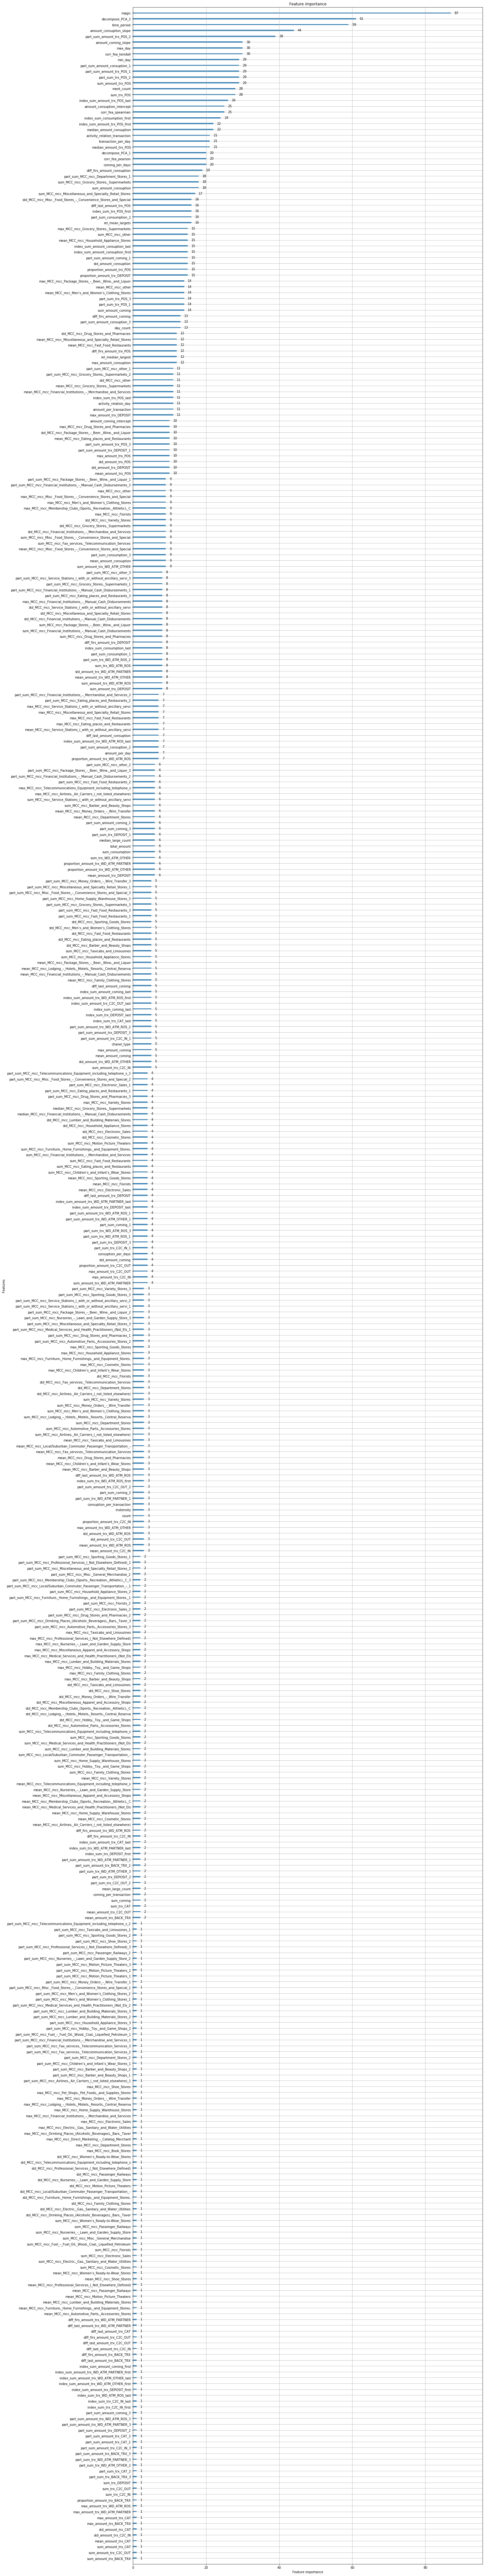

In [126]:
lightgbm.plot_importance(model_lg,figsize=(20,150))

In [143]:
df_features.loc[:,'target_flag'] = groups['target_flag'].last()

In [137]:
train_data = df_features.loc[df_features.target_flag.dropna().index,:]

In [140]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=201805)

lgb_data_train = lightgbm.Dataset(train_data.drop(['target_flag'],axis=1), 
                             train_data['target_flag'], 
                             free_raw_data=False
                            )

params = {
    'objective':'binary', 
    'metric': 'auc',
    'learning_rate': 0.012, 
    'random_state':4242442,
    'subsample':0.33,
    'class_weight':'balanced',
    'colsample_bytree':0.33,
    'reg_lambda':4
}

h = lightgbm.cv(params, 
           lgb_data_train, 
           num_boost_round=10000,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(train_data, train_data['target_flag'])
          )

[10]	cv_agg's auc: 0.857287 + 0.0105748
[20]	cv_agg's auc: 0.860361 + 0.00985381
[30]	cv_agg's auc: 0.862735 + 0.00981978
[40]	cv_agg's auc: 0.86414 + 0.00979915
[50]	cv_agg's auc: 0.864572 + 0.0100852
[60]	cv_agg's auc: 0.865144 + 0.0101369
[70]	cv_agg's auc: 0.865217 + 0.010031
[80]	cv_agg's auc: 0.866061 + 0.0100489
[90]	cv_agg's auc: 0.866761 + 0.00999714
[100]	cv_agg's auc: 0.867208 + 0.0100587
[110]	cv_agg's auc: 0.86752 + 0.00997749
[120]	cv_agg's auc: 0.867782 + 0.00987365
[130]	cv_agg's auc: 0.868048 + 0.00987642
[140]	cv_agg's auc: 0.868447 + 0.0098721
[150]	cv_agg's auc: 0.868566 + 0.00993855
[160]	cv_agg's auc: 0.868936 + 0.00983103
[170]	cv_agg's auc: 0.869593 + 0.00980345
[180]	cv_agg's auc: 0.869961 + 0.00990608
[190]	cv_agg's auc: 0.870501 + 0.00989778
[200]	cv_agg's auc: 0.870775 + 0.00988764
[210]	cv_agg's auc: 0.871143 + 0.00988988
[220]	cv_agg's auc: 0.871405 + 0.00986255
[230]	cv_agg's auc: 0.871853 + 0.00979799
[240]	cv_agg's auc: 0.872208 + 0.00979415
[250]	cv_ag

я опускаю код для задачи регрессии, так как я решал ее на тех же самых признаках, целевая пременная просто логарифмировалась
2 причины моего фейла с задачей регрессии:  
* ей я занялся буквально в последний день, единственный адекватный сабмит был самым первым, предсказания были сделанным моделью с дефолтными параметрами, чтобы посмотреть результат. а на двух следующих сабмитах я забыл обратить обратить логарифмическое преобразование целевой переменной и в результате получил чепуху. подбор гиперпараметров улучшил бы результат в любом случае, хотя и неизвестно насколько сильно
* для регрессии выбросы куда чуствительней, чем для классификации. следовало хоть как-то почистить данные(хотя бы обрезать по какими-либо персентилям)

пояснение насчет PCA

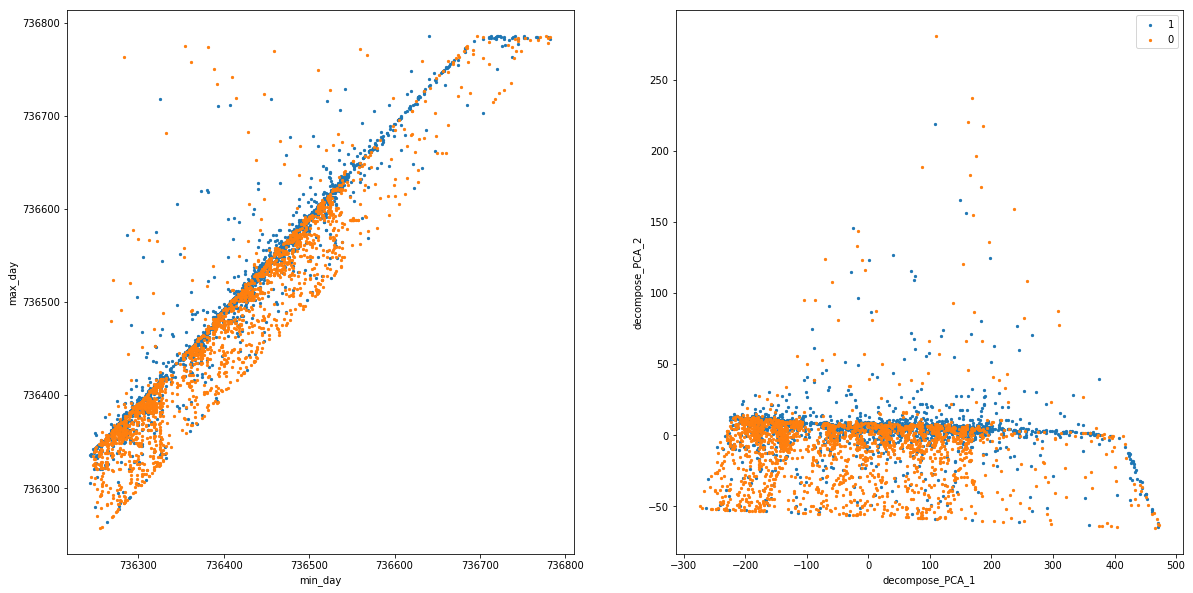

In [163]:
fea_name = ['decompose_PCA_1','decompose_PCA_2','min_day','max_day']
fig,axes = plt.subplots(1,2,figsize=(20,10))
for ax,cols in zip(axes,(['min_day','max_day'],['decompose_PCA_1','decompose_PCA_2'])):
    ax.scatter(pos_data[cols[0]],pos_data[cols[1]],label='1',s=5)
    ax.scatter(neg_data[cols[0]],neg_data[cols[1]],label='0',s=5)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
ax.legend(loc='best')

на обоих изображениях видно, что данные в принципе не так плохо разделимы, но для деревьев решений второй вариант   
значительно лучше первого(ну для неглубоких деревье точно лучше)  
PCA же в данном случае это просто дает ортогональное преобразование точек  
но все-таки провермя, правда ли второй вариант для деревьев решений лучше

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [200]:
with_pca_transform = []
without_pca_transform = []
for max_depth in range(2,30):
    with_pca_transform.append(np.mean(cross_val_score(scoring='roc_auc',
                X=train_data[['decompose_PCA_1','decompose_PCA_2']],
                estimator=DecisionTreeClassifier(random_state=42,max_depth=max_depth),
                y=train_data.target_flag,cv=KFold(random_state=42,n_splits=5), ))
    )
    without_pca_transform.append(np.mean(cross_val_score(scoring='roc_auc',
                X=train_data[['min_day','max_day']],
                estimator=DecisionTreeClassifier(random_state=42,max_depth=max_depth),
                y=train_data.target_flag,cv=KFold(random_state=42,n_splits=5), ))
                        )

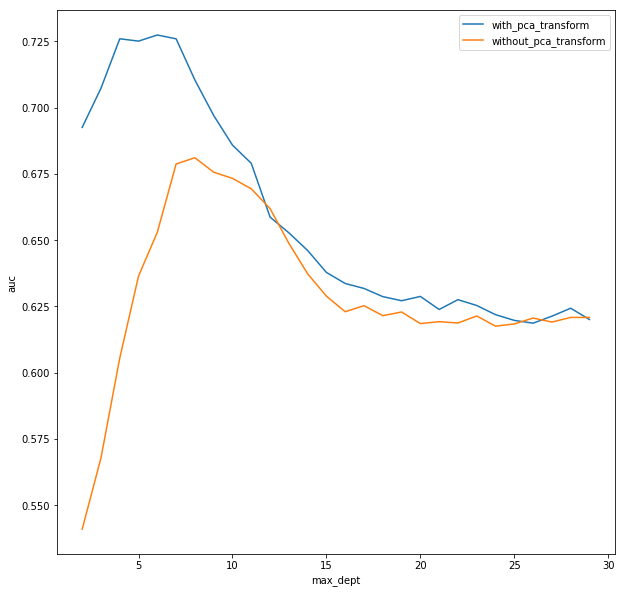

In [206]:
_,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot( range(2,30), with_pca_transform , label = 'with_pca_transform')
ax.plot( range(2,30), without_pca_transform ,label = 'without_pca_transform')
ax.set_xlabel('max_dept')
ax.set_ylabel('auc')
ax.legend(loc='best')